In [1]:
import os
import sys

ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
SRC = os.path.join(ROOT, 'src')
sys.path.append(SRC)

import mirdata
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pandas as pd
from collections import defaultdict
import seaborn as sns


## Load Dataset and Extract Tempo

In [2]:
# ----- Load Dataset -----
data_home = '../../../datasets/CMR'

carn = mirdata.initialize('compmusic_carnatic_rhythm', version='full_dataset_1.0', data_home=data_home, )
carn_tracks = carn.load_tracks()
carn_keys = list(carn_tracks.keys())

In [3]:
track_tempo_list = [] # to store tempo metrics for each track
taala_cycle_lengths = defaultdict(list) # to store cycle lengths for each taala

for k in carn_keys:
    beat_times = carn_tracks[k].beats.times
    beat_pos = carn_tracks[k].beats.positions.astype(int)
    downbeat_times = beat_times[beat_pos == 1]
    
    if beat_times is None or len(beat_times) < 2:
        continue  # skip if not enough beat times

    track_taala = carn_tracks[k].taala

    ibis = np.diff(beat_times)
    ibis = ibis[ibis > 0]  # exclude invalid intervals

    if len(ibis) == 0:
        continue
    
    bpm_track = 60.0 / ibis

    cycle_length = np.diff(downbeat_times)
    cycle_length = cycle_length[cycle_length > 0]  # exclude invalid intervals
    taala_cycle_lengths[track_taala].extend(cycle_length)
    
    track_tempo_list.append({
        'track_id': k,
        'taala': track_taala,
        'median_bpm': np.median(bpm_track),
        'min_bpm': bpm_track.min(),
        'max_bpm': bpm_track.max(),
        'min_cycle_length': cycle_length.min(),
        'max_cycle_length': cycle_length.max(),
        'median_cycle_length': np.median(cycle_length)
    })

In [4]:
# Build a DataFrame from the list of dicts
tempo_df = pd.DataFrame(track_tempo_list)
tempo_df.head()

,track_id,taala,median_bpm,min_bpm,max_bpm,min_cycle_length,max_cycle_length,median_cycle_length
0,10001,adi,77.799524,62.092261,97.721302,5.611338,6.528526,6.154898
1,10002,adi,93.409202,80.722412,110.277698,4.881860,5.382948,5.147324
2,10003,adi,82.227545,71.407404,98.960421,5.605805,6.034830,5.850295
3,10004,adi,96.332078,74.551943,120.982133,4.408776,5.357619,5.005986
4,10005,adi,82.772893,71.923732,101.969195,5.204988,6.265216,5.778458


### Merge with track-wise results

In [5]:
df = pd.read_csv("summary_results_beat_this_ft.csv")  # absolute path is safest
#df = pd.read_csv("summary_results_tcn_fs.csv")  # absolute path is safest

In [6]:
df['track_id'] = pd.to_numeric(df['track_id'], errors='coerce').astype('Int64')
tempo_df['track_id'] = pd.to_numeric(tempo_df['track_id'], errors='coerce').astype('Int64')

df = df.merge(tempo_df.drop(columns=['taala'], errors='ignore'), on='track_id', how='right')
print(df.head())

   track_id taala    beat_F  beat_CMLt  beat_AMLt  downbeat_F  downbeat_CMLt  \
0     10001   adi  0.552069   0.308826   0.308826    0.304924       0.018727   
1     10002   adi  0.685598   0.358846   0.398164    0.338686       0.000000   
2     10003   adi  0.907649   0.871829   0.871829    0.388263       0.001745   
3     10004   adi  0.890249   0.840465   0.840465    0.531925       0.002819   
4     10005   adi  0.984285   0.987162   0.987162    0.648919       0.005725   

   downbeat_AMLt  median_bpm    min_bpm     max_bpm  min_cycle_length  \
0       0.363056   77.799524  62.092261   97.721302          5.611338   
1       0.248579   93.409202  80.722412  110.277698          4.881860   
2       0.209938   82.227545  71.407404   98.960421          5.605805   
3       0.758748   96.332078  74.551943  120.982133          4.408776   
4       0.929654   82.772893  71.923732  101.969195          5.204988   

   max_cycle_length  median_cycle_length  
0          6.528526             6.154

## Plots

### Tempo Analysis

In [7]:
# Config
taala_order = ['adi', 'rupakam', 'mishraChapu', 'khandaChapu']
#violin_colors = ["#F72585", "#7209B7", "#4361EE", "#5FA8D3"]
violin_colors = ["#D1492E", "#F4D35E", "#2FBF71", "#0B6E4F"]
taala_to_color = {t: violin_colors[i % len(violin_colors)] for i, t in enumerate(taala_order)}

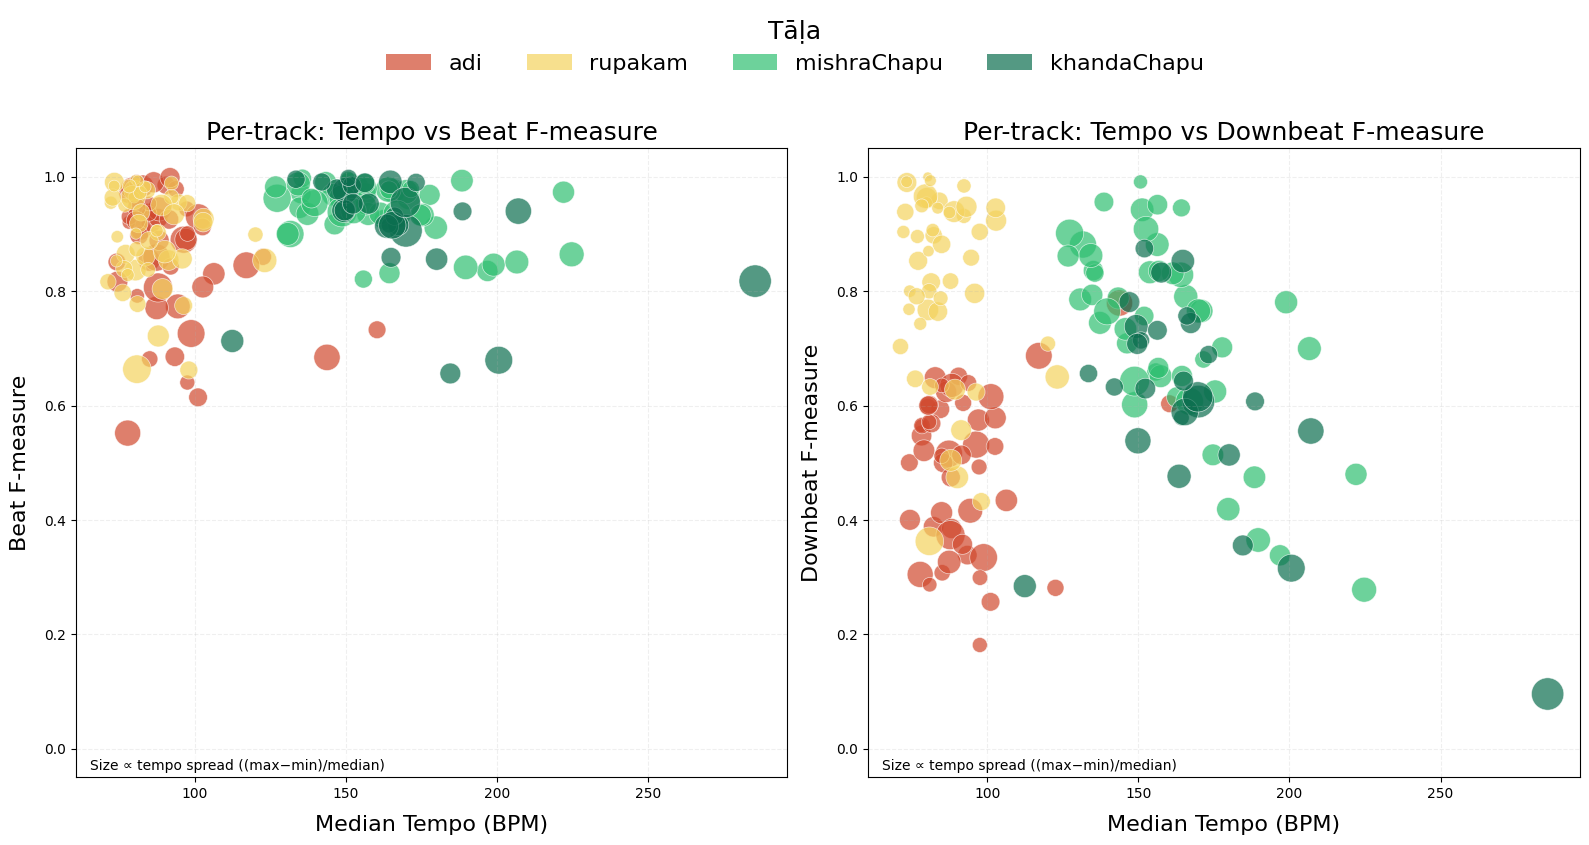

In [ ]:
# Prepare data
df_plot = df.copy()
# Relative tempo spread (percent of median)
df_plot['tempo_rel'] = (df_plot['max_bpm'] - df_plot['min_bpm']) / (df_plot['median_bpm'] + 1e-9)

# Size scaling
min_r = df_plot['tempo_rel'].min()
max_r = df_plot['tempo_rel'].max()
size = 50 + 500 * (df_plot['tempo_rel'] - min_r) / (max_r - min_r + 1e-12)

# Colors by taala
colors = df_plot['taala'].map(lambda t: taala_to_color.get(t, '#999999'))

# Subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

for ax, f_col, y_label, title in [
    (ax1, 'beat_F', 'Beat F-measure', 'Per-track: Tempo vs Beat F-measure'),
    (ax2, 'downbeat_F', 'Downbeat F-measure', 'Per-track: Tempo vs Downbeat F-measure')
]:
    ax.scatter(
        df_plot['median_bpm'],
        df_plot[f_col],
        s=size,
        c=colors,
        alpha=0.7,
        edgecolor='white',
        linewidth=0.5
    )
    ax.set_xlabel('Median Tempo (BPM)', fontsize=16, labelpad=10)
    ax.set_ylabel(y_label, fontsize=16, labelpad=10)
    ax.set_title(title, fontsize=18)
    ax.grid(True, linestyle='--', alpha=0.2)
    ax.set_ylim(-0.05, 1.05)

legend_handles = [Patch(facecolor=taala_to_color.get(t, '#999999'), alpha=0.7, edgecolor='none', label=t) for t in taala_order]
fig.legend(
    handles=legend_handles,
    title='Tāḷa',
    frameon=False,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.05),  # slightly below the suptitle
    ncol=len(taala_order),
    borderaxespad=0.0,
    fontsize=16,
    title_fontsize=18
)

# Put a small caption inside each subplot
size_label = r"Size ∝ tempo spread ((max−min)/median)"
for ax in (ax1, ax2):
    ax.text(
        0.02, 0.03, size_label,
        transform=ax.transAxes,
        ha='left', va='top',
        fontsize=10,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7, linewidth=0.0, pad=0.3)
    )

# Leave room at the top for both
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

### Cycle-length Analysis

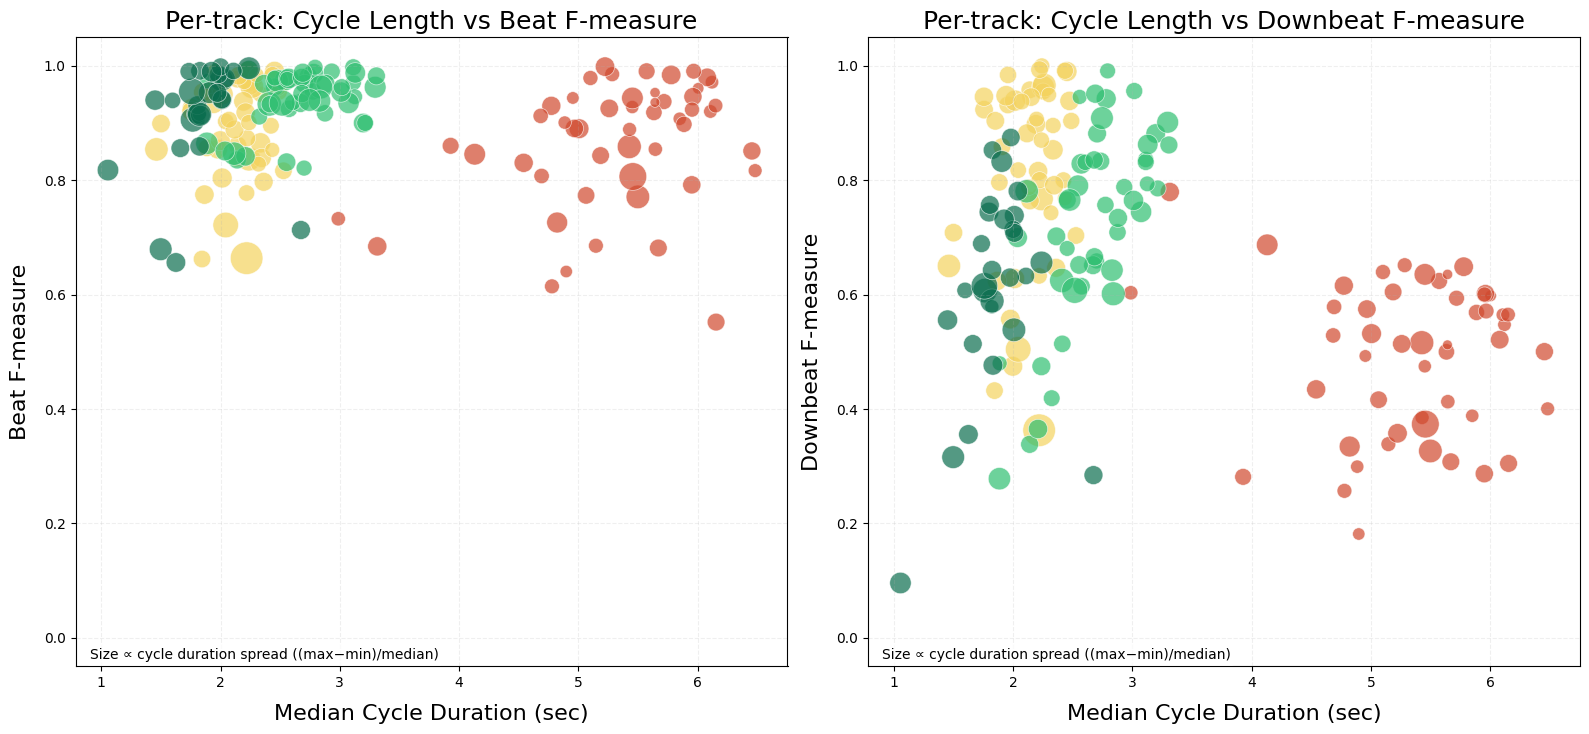

In [9]:
# Prepare data
df_plot = df.copy()
# Relative tempo spread (percent of median)
df_plot['cycle_length_rel'] = (df_plot['max_cycle_length'] - df_plot['min_cycle_length']) / (df_plot['median_cycle_length'] + 1e-9)

# Or multiplicative spread (log-scale)
# df_plot['tempo_rel'] = np.log((df_plot['max_bpm'] + 1e-9) / (df_plot['min_bpm'] + 1e-9))

# Size scaling
min_r = df_plot['cycle_length_rel'].min()
max_r = df_plot['cycle_length_rel'].max()
size = 50 + 500 * (df_plot['cycle_length_rel'] - min_r) / (max_r - min_r + 1e-12)

# Colors by taala
colors = df_plot['taala'].map(lambda t: taala_to_color.get(t, '#999999'))

# Subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

for ax, f_col, y_label, title in [
    (ax1, 'beat_F', 'Beat F-measure', 'Per-track: Cycle Length vs Beat F-measure'),
    (ax2, 'downbeat_F', 'Downbeat F-measure', 'Per-track: Cycle Length vs Downbeat F-measure')
]:
    ax.scatter(
        df_plot['median_cycle_length'],
        df_plot[f_col],
        s=size,
        c=colors,
        alpha=0.7,
        edgecolor='white',
        linewidth=0.5
    )
    ax.set_xlabel('Median Cycle Duration (sec)', fontsize=16, labelpad=10)
    ax.set_ylabel(y_label, fontsize=16, labelpad=10)
    ax.set_title(title, fontsize=18)
    ax.grid(True, linestyle='--', alpha=0.2)
    ax.set_ylim(-0.05, 1.05)
    
# Legend
legend_handles = [Patch(facecolor=taala_to_color.get(t, '#999999'), edgecolor='none', label=t) for t in taala_order]

# Put a small caption inside each subplot
size_label = r"Size ∝ cycle duration spread ((max−min)/median)"
for ax in (ax1, ax2):
    ax.text(
        0.02, 0.03, size_label,
        transform=ax.transAxes,
        ha='left', va='top',
        fontsize=10,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7, linewidth=0.0, pad=0.3)
    )

# Leave room at the top for both
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()